In [241]:
import networkx as nx
import os.path as osp
import os
from node2vec import random_walk, simple_biaised_random_walk, biaised_random_walk
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from time import time
import multiprocessing as mp
from functools import partial
import seaborn as sns
import re
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [242]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [3]:
#for network_name_ in os.listdir(path_to_data_gml):
#    G = nx.read_gml(osp.join(path_to_data_gml, network_name_))
#    print("{}: Nodes ({}), Edges : ({})".format(network_name_, len(G.nodes), len(G.edges)))

In [248]:
path_to_data_gml = '../data/gml'
network_name = 'cora.gml'
G = nx.read_gml(osp.join(path_to_data_gml, network_name))

In [249]:
# Clean graph 
G.remove_edges_from(nx.selfloop_edges(G))
isolated_nodes = nx.isolates(G)
G.remove_nodes_from(list(isolated_nodes))
core_nb = nx.core_number(G)

In [260]:
def rw_to_txt(rw, fname='tmp.txt', fdir="rw_cora"):
    if not osp.exists(fdir):
        os.mkdir(fdir)
    with open(osp.join(fdir, fname), 'w') as f:
        for rw_line in rw:
            f.writelines(','.join(rw_line) + '\n')
    print('Saved to {}'.format(fname))

In [251]:
def from_txt(fdir):
    with open(fdir, "r") as f:
        lines = f.readlines()
    rw = [] 
    for l in lines:
        tmp = lines[0].split(",")
        rw.append(tmp[:-1] + [tmp[-1].rstrip()])
    return rw

# Graphs stats

In [7]:
degree_list = [deg for node, deg in G.degree]

In [8]:
degree, counts = np.unique(degree_list, return_counts=True)

In [9]:
cum_count = [sum(counts[i:]) for i in range(len(counts))]

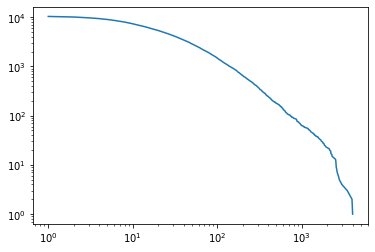

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(degree, cum_count)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [39]:
nx.average_shortest_path_length(G)

2.3823521566933232

# Generate biaised random walks

## Utils functions

In [252]:
def _random_walk(node, rep, args): #Simple utils function to compute the repetition of the rw
    return [random_walk(node=node, **args) for _ in range(rep)]

In [253]:
def generate_rw(args):
    core_nb = nx.core_number(args['graph'])
    start_time = time()
    p = mp.Pool(mp.cpu_count())
    rep = args.pop("rep", 12)
    multiprocess_rw = partial(_random_walk, rep=rep, args=args) 
    walks = p.map(multiprocess_rw, [n for n in G.nodes])
    walks = np.array(walks).reshape(np.array(walks).shape[0], -1).tolist() # TODO: pas beau
    print("Generation time: {} - {} random walks".format(time()-start_time, len(walks)))
    rw_to_txt(walks, fname="node2vec_{}rep_{len_walk:}len_{p:.2f}p_{q:.2f}q.txt".format(rep, **args))
    return walks

In [254]:
def _simple_biaised_random_walk(node, rep, args): #Simple utils function to compute the repetition of the rw
    return [simple_biaised_random_walk(node=node, **args) for _ in range(rep)]

In [255]:
def generate_simple_biaised_rw(args):
    core_nb = nx.core_number(args['graph'])
    start_time = time()
    p = mp.Pool(mp.cpu_count())
    rep = args.pop("rep", 10)
    multiprocess_simple_biaised_rw = partial(_simple_biaised_random_walk, rep=rep, args=args) 
    walks = p.map(multiprocess_simple_biaised_rw, [n for n in G.nodes])
    walks = np.array(walks).reshape(np.array(walks).shape[0], -1).tolist() # TODO: pas beau
    print("Generation time: {} - {} random walks".format(time()-start_time, len(walks)))
    rw_to_txt(walks, fname="node2vec_{}rep_{len_walk:}len_{alpha:.2f}alpha_{beta:.2f}beta.txt".format(rep, **args))
    return walks

In [256]:
def _biaised_random_walk(node, rep, args): #Simple utils function to compute the repetition of the rw
    return [biaised_random_walk(node=node, **args) for _ in range(rep)]

In [257]:
def generate_biaised_rw(args):
    core_nb = nx.core_number(args['graph'])
    start_time = time()
    p = mp.Pool(mp.cpu_count())
    rep = args.pop("rep", 10)
    multiprocess_biaised_rw = partial(_biaised_random_walk, rep=rep, args=args) 
    walks = p.map(multiprocess_biaised_rw, [n for n in G.nodes])
    walks = np.array(walks).reshape(np.array(walks).shape[0], -1).tolist() # TODO: pas beau
    print("Generation time: {} - {} random walks".format(time()-start_time, len(walks)))
    rw_to_txt(walks, fname="node2vec_{}rep_{len_walk:}len_{a1:.2f}a1_{a2:.2f}a2_{p1:.2f}p1_{p2:.2f}p2_{q1:.2f}q1_{q2:.2f}q2.txt".format(rep, **args))
    return walks

## Generation

Transition probabilities :

1. Simple biaised random walk : $\pi_{vx} = \alpha(v, x) w_{vx}$
    
    
$$ \alpha_{\alpha\beta}(v, x) =
\left\{
    \begin{array}{ll}
        \frac{1}{\alpha} \ if \ k_{x} < k_{v} \\
        1 \ if \ k_{x} = k_{v} \\
        \frac{1}{\beta} \ otherwise\\
    \end{array}
\right.
$$
  
Thus, if 

- $if \alpha << 1 << \beta $, random walk biaised towards lower k-core numbers
- $if \beta << 1 << \alpha $, random walk biaised towards higher k-core numbers


2. Biaised random walk $\pi_{vx} = \alpha(t, x) w_{vx}$


$$ \alpha_{\alpha\beta}(t, x) =
\left\{
    \begin{array}{ll}
        \frac{1}{p_1} \ if \ d_{tx} = 0 \ and \ k_{x} \lt k_{v} \\
        \frac{1}{p_2} \ if \ d_{tx} = 0 \ and \ k_{x} \ge k_{v} \\
        \frac{1}{a_1} \ if \ d_{tx} = 1 \ and \ k_{x} \lt k_{v} \\
        \frac{1}{a_2} \ if \ d_{tx} = 1 \ and \ k_{x} \ge k_{v} \\
        \frac{1}{q_1} \ if \ d_{tx} = 2 \ and \ k_{x} \lt k_{v} \\
        \frac{1}{q_2} \ if \ d_{tx} = 2 \ and \ k_{x} \ge k_{v} \\
        \end{array}
\right.
$$

In [258]:
len_walk = 40
rep = 10

In [2]:
import numpy as np

In [6]:
w_ = [[node for walk in l for node in walk] for l in ]

In [8]:
len(w_[0])

400

In [3]:
w = np.random.uniform(0, 10, size=(100, 10, 40)).tolist()

### Node2vec random walk

In [4]:
args_rw = {"graph":G, "len_walk":len_walk, "rep": rep, "p":1, "q":1}

NameError: name 'G' is not defined

In [22]:
walks = generate_rw(args_rw)

Generation time: 319.96074080467224 - 10312 random walks
Saved to node2vec_10rep_40len_1.00p_1.00q.txt


Process ForkPoolWorker-6:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/miniconda3/envs/cvn_026/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/miniconda3/envs/cvn_026/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/miniconda3/envs/cvn_026/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/miniconda3/envs/cvn_026/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/miniconda3/envs/cvn_026/lib/python3.6/multiprocessing/proc

### Simple biaised random walk

In [29]:
args_simple_biaised = {"graph":G, 'len_walk':len_walk, "rep": rep, 'alpha':1, 'beta':1, 'core_nb':core_nb}

In [ ]:
# Parameters (alpha, beta)
 
params = [(.1, 1), (1, .1), (1, 1), (.01, 1), (1, .01), (.1, .01), (.01, .1), (1, 10), (10, 1)]
for (alpha, beta) in params:
    _args = args_simple_biaised
    _args["alpha"], _args["beta"] = alpha, beta
    walks = generate_simple_biaised_rw(_args)

Generation time: 20.87173318862915 - 2708 random walks
Saved to node2vec_10rep_40len_0.10alpha_1.00beta.txt
Generation time: 22.59573793411255 - 2708 random walks
Saved to node2vec_10rep_40len_1.00alpha_0.10beta.txt
Generation time: 25.47354817390442 - 2708 random walks
Saved to node2vec_10rep_40len_1.00alpha_1.00beta.txt
Generation time: 29.319054126739502 - 2708 random walks
Saved to node2vec_10rep_40len_0.01alpha_1.00beta.txt
Generation time: 24.23146414756775 - 2708 random walks
Saved to node2vec_10rep_40len_1.00alpha_0.01beta.txt
Generation time: 23.10247302055359 - 2708 random walks
Saved to node2vec_10rep_40len_0.10alpha_0.01beta.txt
Generation time: 27.500937938690186 - 2708 random walks
Saved to node2vec_10rep_40len_0.01alpha_0.10beta.txt
Generation time: 31.43652105331421 - 2708 random walks
Saved to node2vec_10rep_40len_1.00alpha_10.00beta.txt


In [14]:
# walks = generate_simple_biaised_rw(args_simple_biaised)

Generation time: 1.4483888149261475 - 1 random walks
Saved to node2vec_20rep_50len_1alpha_1beta.txt


### Biaised random walk

In [182]:
args_biaised_rw = {"graph":G, 'len_walk':len_walk, 'rep':rep, 'a1':1, 'a2':1, 'p1':1,'p2':1, 'q1':1,'q2':1, 'core_nb':core_nb}

In [183]:
# Parameters : (a1 ,a2, p1, p2, q1, q2)
params = [(1, 1, .01, .1, 1, 1), (1, 1, .1, .01, 1, 1),
         (1, 1, 1, 1, .1, .01), (1, 1, 1, 1, .01, .1),
         (.1, .01, 1, 1, 1, 1), (.01, .1, 1, 1, 1, 1)]
for (a1 ,a2, p1, p2, q1, q2) in params:
    _args = args_biaised_rw
    _args.update({k:v for k, v in zip(["a1" ,"a2", "p1", "p2", "q1", "q2"] ,(a1 ,a2, p1, p2, q1, q2))})
    generate_biaised_rw(_args)

Generation time: 367.9871962070465 - 10312 random walks
Saved to node2vec_10rep_40len_1.00a1_1.00a2_0.01p1_0.10p2_1.00q1_1.00q2.txt
Generation time: 498.297061920166 - 10312 random walks
Saved to node2vec_10rep_40len_1.00a1_1.00a2_0.10p1_0.01p2_1.00q1_1.00q2.txt
Generation time: 430.9120056629181 - 10312 random walks
Saved to node2vec_10rep_40len_1.00a1_1.00a2_1.00p1_1.00p2_0.10q1_0.01q2.txt
Generation time: 256.5615060329437 - 10312 random walks
Saved to node2vec_10rep_40len_1.00a1_1.00a2_1.00p1_1.00p2_0.01q1_0.10q2.txt
Generation time: 15354.390569925308 - 10312 random walks
Saved to node2vec_10rep_40len_0.10a1_0.01a2_1.00p1_1.00p2_1.00q1_1.00q2.txt
Generation time: 14208.063638210297 - 10312 random walks
Saved to node2vec_10rep_40len_0.01a1_0.10a2_1.00p1_1.00p2_1.00q1_1.00q2.txt


In [37]:
# walks = generate_biaised_rw(args_biaised_rw)

Generation time: 9.019586086273193 - 1 random walks
Saved to node2vec_20rep_50len_1.00a1_1.00a2_1.00p1_1.00p2_1.00q1_1.00q2.txt


# Label Prediction

### Read save random_walk

In [19]:
walks = from_txt("./rw/node2vec_10rep_40len_0.10alpha_1.00beta.txt")

In [31]:
len(walks[0])

400

### Utils functions

In [162]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

In [33]:
def transform(x):
    return sorted(x)[0] if type(x)==list else x

In [60]:
def transform_class(Y_test, y_pred):
    y_true = []
    for i, el in enumerate(Y_test):
        if isinstance(el, int):
            y_true.append(el)
        elif y_pred[i] in el:
            y_true.append(y_pred[i])
        else:
            y_true.append(el[0])
    return y_true

In [163]:
def compute_stats(walks):
    model = Word2Vec(walks, size=100, window=3, min_count=0, sg=1, hs=1)
    wv = model.wv

    repr_mat = wv.vectors
    index2word = wv.index2word
    X = repr_mat
    Y = np.array([G.nodes[word]["community"] for word in index2word])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.6)

    model = LogisticRegression(penalty='l2')
    model.fit(X_train, list(map(transform,Y_train)))
    y_pred = model.predict(X_test)
    y_true = transform_class(Y_test, y_pred)
    
    f1 = f1_score(y_true, y_pred, average="micro")
    recall = recall_score(y_true, y_pred, average="micro")
    precision = precision_score(y_true, y_pred, average="micro")

    print(f"F1: {f1}, precision: {precision}, recall: {recall}")
    
    return f1, precision, recall  

### Experiment utils

In [96]:
def get_rw_params(fname):
    rw_pattern = "^node2vec_([0-9]+)rep_([0-9]+)len_([0-9]+.[0-9]{2})p_([0-9]+.[0-9]{2})q.txt$"
    match = re.search(rw_pattern, fname)
    params = {'len_walk':match.group(1), "rep": match.group(2), 'p':match.group(3), 'q':match.group(4)}
    return params

In [112]:
def get_simple_biaised_rw_params(fname):
    simple_biaised_pattern = "^node2vec_([0-9]+)rep_([0-9]+)len_([0-9]+.[0-9]{2})alpha_([0-9]+.[0-9]{2})beta.txt$"
    match = re.search(simple_biaised_pattern, fname)
    params = {'len_walk':match.group(1), "rep": match.group(2), 'alpha':match.group(3), 'beta':match.group(4)}
    return params

In [98]:
def get_biaised_rw_params(fname):
    biaised_pattern = "^node2vec_([0-9]+)rep_([0-9]+)len_([0-9]+.[0-9]{2})a1_([0-9]+.[0-9]{2})a2_([0-9]+.[0-9]{2})p1_([0-9]+.[0-9]{2})p2_([0-9]+.[0-9]{2})q1_([0-9]+.[0-9]{2})q2.txt$"
    match = re.search(biaised_pattern, fname)
    params = {'len_walk': match.group(1), 'rep':match.group(2), 'a1':match.group(3), 'a2':match.group(4), 'p1':match.group(5),'p2':match.group(6), 'q1':match.group(7),'q2':match.group(8)}
    return params

### Predict

In [176]:
if not osp.exists("output"):
    os.makedirs("output")

In [179]:
# Simple biaised RW
res = None
simple_biaised_pattern = "node2vec_([0-9]+)rep_([0-9]+)len_([0-9]+.[0-9]{2})alpha_([0-9]+.[0-9]{2})beta.txt"
files = [fname for fname in os.listdir('rw') if re.search(simple_biaised_pattern, fname)]
for i, fname in enumerate(files):
    print(f'Processing {fname} - ({i+1}/{len(files)})')
    walk = from_txt(osp.join("rw", fname))
    output = get_simple_biaised_rw_params(fname)
    f1, precision, recall = compute_stats(walks)
    output["f1_score"], output["precision"], output["recall"]  = f1, precision, recall
    if res is None:
        res = pd.DataFrame(output, index=[0]) 
    else:
        res = res.append(pd.DataFrame(output, index=[res.shape[0]]))
        
res.to_csv(osp.join('output', 'simple_biaised.csv'))

Processing node2vec_10rep_40len_1.00alpha_1.00beta.txt - (1/9)
F1: 0.3773432449903038, precision: 0.3773432449903038, recall: 0.3773432449903038
Processing node2vec_10rep_40len_0.10alpha_0.01beta.txt - (2/9)
F1: 0.37120232708468, precision: 0.37120232708468004, recall: 0.37120232708468004
Processing node2vec_10rep_40len_0.01alpha_1.00beta.txt - (3/9)
F1: 0.3695862960568843, precision: 0.3695862960568843, recall: 0.3695862960568843
Processing node2vec_10rep_40len_10.00alpha_1.00beta.txt - (4/9)
F1: 0.37588881706528765, precision: 0.37588881706528765, recall: 0.37588881706528765
Processing node2vec_10rep_40len_1.00alpha_0.01beta.txt - (5/9)
F1: 0.3695862960568843, precision: 0.3695862960568843, recall: 0.3695862960568843
Processing node2vec_10rep_40len_1.00alpha_0.10beta.txt - (6/9)
F1: 0.36651583710407243, precision: 0.3665158371040724, recall: 0.3665158371040724
Processing node2vec_10rep_40len_1.00alpha_10.00beta.txt - (7/9)
F1: 0.3632837750484809, precision: 0.3632837750484809, recall

Text(0.5, 1.0, 'f1_score as f(alpha, beta)')

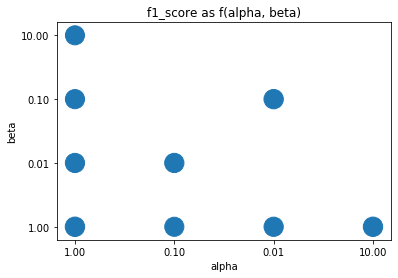

In [180]:
size = res["precision"]*1000
plt.scatter(res["alpha"], res["beta"], s = size)
plt.xlabel("alpha")
plt.ylabel("beta")
plt.title("f1_score as f(alpha, beta)")

In [185]:
#  biaised RW
res = None
biaised_pattern = "^node2vec_([0-9]+)rep_([0-9]+)len_([0-9]+.[0-9]{2})a1_([0-9]+.[0-9]{2})a2_([0-9]+.[0-9]{2})p1_([0-9]+.[0-9]{2})p2_([0-9]+.[0-9]{2})q1_([0-9]+.[0-9]{2})q2.txt$"
files = [fname for fname in os.listdir('rw') if re.search(biaised_pattern, fname)]
for i, fname in enumerate(files):
    print(f'Processing {fname} - ({i+1}/{len(files)})')
    walk = from_txt(osp.join("rw", fname))
    output = get_biaised_rw_params(fname)
    f1, precision, recall = compute_stats(walks)
    output["f1_score"], output["precision"], output["recall"]  = f1, precision, recall
    if res is None:
        res = pd.DataFrame(output, index=[0]) 
    else:
        res = res.append(pd.DataFrame(output, index=[res.shape[0]]))
        
res.to_csv(osp.join('output', 'biaised.csv'))

Processing node2vec_10rep_40len_1.00a1_1.00a2_0.10p1_0.01p2_1.00q1_1.00q2.txt - (1/6)
F1: 0.3663542340012928, precision: 0.3663542340012928, recall: 0.3663542340012928
Processing node2vec_10rep_40len_0.01a1_0.10a2_1.00p1_1.00p2_1.00q1_1.00q2.txt - (2/6)
F1: 0.37766645119586295, precision: 0.37766645119586295, recall: 0.37766645119586295
Processing node2vec_10rep_40len_1.00a1_1.00a2_0.01p1_0.10p2_1.00q1_1.00q2.txt - (3/6)
F1: 0.3757272139625081, precision: 0.3757272139625081, recall: 0.3757272139625081
Processing node2vec_10rep_40len_1.00a1_1.00a2_1.00p1_1.00p2_0.01q1_0.10q2.txt - (4/6)
F1: 0.36651583710407243, precision: 0.3665158371040724, recall: 0.3665158371040724
Processing node2vec_10rep_40len_1.00a1_1.00a2_1.00p1_1.00p2_0.10q1_0.01q2.txt - (5/6)
F1: 0.3577892695539754, precision: 0.35778926955397544, recall: 0.35778926955397544
Processing node2vec_10rep_40len_0.10a1_0.01a2_1.00p1_1.00p2_1.00q1_1.00q2.txt - (6/6)
F1: 0.36877828054298645, precision: 0.36877828054298645, recall: 0.3

In [186]:
res

,len_walk,rep,a1,a2,p1,p2,q1,q2,f1_score,precision,recall
0,10,40,1.00,1.00,0.10,0.01,1.00,1.00,0.373303,0.373303,0.373303
1,10,40,0.01,0.10,1.00,1.00,1.00,1.00,0.366677,0.366677,0.366677
2,10,40,1.00,1.00,0.01,0.10,1.00,1.00,0.363284,0.363284,0.363284
3,10,40,1.00,1.00,1.00,1.00,0.01,0.10,0.367162,0.367162,0.367162
4,10,40,1.00,1.00,1.00,1.00,0.10,0.01,0.370394,0.370394,0.370394
5,10,40,0.10,0.01,1.00,1.00,1.00,1.00,0.357304,0.357304,0.357304
6,10,40,1.00,1.00,0.10,0.01,1.00,1.00,0.366354,0.366354,0.366354
7,10,40,0.01,0.10,1.00,1.00,1.00,1.00,0.377666,0.377666,0.377666
8,10,40,1.00,1.00,0.01,0.10,1.00,1.00,0.375727,0.375727,0.375727
9,10,40,1.00,1.00,1.00,1.00,0.01,0.10,0.366516,0.366516,0.366516


### Analyse results

In [224]:
dict_core_walk = {}
core_nb = nx.core_number(G)
for node_walk in tqdm(walks):
    walk_core_number = []
    for node in node_walk[1:]:
        walk_core_number.append(core_nb[node])
    dict_core_walk[node_walk[0]] = walk_core_number
    

100%|██████████| 10312/10312 [00:00<00:00, 17585.21it/s]


In [225]:
sorted_dict = sorted(dict_core_walk.items(), key=lambda kv: core_nb[kv[0]])

In [226]:
indx = np.random.choice(np.arange(len(sorted_dict)), size=10)

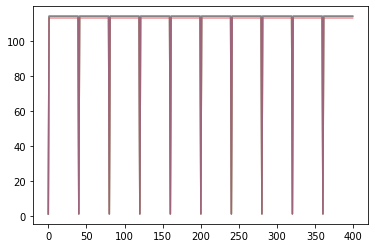

In [240]:
to_draw = np.array(sorted_dict)[:10]
for node, walk in to_draw[:5]:
    plt.plot(np.arange(len(walk)), walk, alpha=.5)
    
plt.show()